<a href="https://colab.research.google.com/github//pylabel-project/samples/blob/main/albumentations.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;
<a href='https://pylabel.readthedocs.io/en/latest/?badge=latest'>
    <img src='https://readthedocs.org/projects/pylabel/badge/?version=latest' alt='Documentation Status' />
</a>
# Using PyLabel and Albumentations 
If you don't have enough images to train a model well, you can use image augmenation to create more samples for training and validation. 
[Albumentations](https://albumentations.ai/) is a popular open-source library for created additional, augmented images as well as the annotations for those images.

You can use PyLabel with Albumentations to take an existing labelled dataset, multiply the number of images using bulk augmentation, and then save the entire augmented dataset of images and 
annotations in COCO, YOLO, or VOC format.

First install the Albumentations and PyLabel packages if they are not installed already. 

In [40]:
%%capture
%pip install pylabel 
%pip install -q -U albumentations

In [41]:
#These commands are currently required if running on Google Colab
%pip uninstall opencv-python-headless
%pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.1.2.30
Uninstalling opencv-python-headless-4.1.2.30:
  Would remove:
    /Users/alex/Code/samples/venv/lib/python3.8/site-packages/cv2/*
    /Users/alex/Code/samples/venv/lib/python3.8/site-packages/opencv_python_headless-4.1.2.30.dist-info/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [42]:
#Import additional packages used in this notebook 
%matplotlib inline

from pylabel import importer
import albumentations as A

import os, zipfile
from pathlib import PurePath
from os.path import exists
from decimal import *
import copy
import cv2
#from matplotlib import pyplot as plt

## Download Custom Dataset 
For this demonstration we will download 100 images from the <a href="https://github.com/pylabel-project/datasets_models#squirrels-and-nuts">squirrels and nuts dataset with annotations in YOLOv5 format.</a> PyLabel can also import datasets in COCO and PASCAL VOC format. 

In [43]:
%%capture
os.makedirs("data/", exist_ok=True)
!wget "https://github.com/pylabel-project/datasets_models/blob/main/squirrelsandnuts/squirrelsandnuts_train.zip?raw=true" -O data/squirrelsandnuts_train.zip
with zipfile.ZipFile("data/squirrelsandnuts_train.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")

In [44]:
#Import annotations as a PyLabel dataset
dataset = importer.ImportYoloV5(path="data/squirrelsandnuts_train/labels/train",
        path_to_images="../../images/train", 
        img_ext="jpeg",
        cat_names=['Squirrel','Nut']
    )
dataset.df.head(3)

,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,...,ann_segmentation,ann_iscrowd,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,
0,../../images/train,2021-07-03T06-30-10-frame_0001.jpeg,NaN,0,960,540,3,NaN,255.024,170.991,...,NaN,NaN,NaN,NaN,NaN,0,Squirrel,NaN,NaN,1
1,../../images/train,2021-07-03T06-47-39-frame_0004.jpeg,NaN,1,960,540,3,NaN,650.016,447.984,...,NaN,NaN,NaN,NaN,NaN,1,Nut,NaN,NaN,1
2,../../images/train,2021-07-03T06-47-39-frame_0004.jpeg,NaN,1,960,540,3,NaN,690.480,422.010,...,NaN,NaN,NaN,NaN,NaN,1,Nut,NaN,NaN,1


The annotations are now stored as a Pandas DataFrame. Let's explore the existing dataset.

In [ ]:
print(f"Number of images: {dataset.analyze.num_images}")
print(f"Distribution of classes:")
dataset.analyze.class_counts 

Number of images: 100
Distribution of classes:


Nut         145
Squirrel     78
Name: cat_name, dtype: int64

## Use albumentations to augment images and bounding boxes
Edit the list of transforms below to reflect augmentations that you want to do for each image. The example below has defintions for 
4 seperate augmentations. Meaning that for each image, 4 additional images will be created. 
Edit the list if you want to create more or fewer augmentations for your dataset. (See [a list of transforms](https://albumentations.ai/docs/getting_started/transforms_and_targets/) performed by Albumentations.)
 

In [45]:
#Edit this list to change the augmentations that are performed on your dataset. 
transforms = [
        [A.HorizontalFlip(p=1), A.GaussianBlur(p=1)],
        [A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2)],
        [A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False,p=1)],
        [A.RandomRain(slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(200, 200, 200), blur_value=7, brightness_coefficient=0.7, rain_type=None, always_apply=False, p=1)]
    ]

To augment the dataset, iterate through the existing annotations and pass them to Albumentations to do the above augmentations. Albumentations will return an augmented image and corresponding bounding boxes. 
The code below will save the new images to your drive and add the annotations the dataframe. 


In [46]:
#Iterate the rows for each image in the dataframe
for img_filename, img_df in dataset.df.groupby('img_filename'):
    img_path = PurePath(dataset.path_to_annotations, str(img_df.iloc[0].img_folder), img_filename)
    img_path_str = str(img_path)
    assert exists(img_path_str), f"File does not exist: {img_path_str}"

    #Create a list of bounding boxes for each image in the dataset  
    bboxes = []
    for index, row in img_df.iterrows():
        #arranges labels in this format [x_min, y_min, x_max, y_max, label]
        #Get bounding box coordinates and make sure that they don't extend beyond image boundary
        xmin = float(Decimal(row.ann_bbox_xmin).max(0))
        ymin = float(Decimal(row.ann_bbox_ymin).max(0))
        xmax = float(Decimal(row.ann_bbox_xmax).min(row.img_width))
        ymax = float(Decimal(row.ann_bbox_ymax).min(row.img_height))
        label = row.cat_name
        
        bboxes.append([xmin, ymin, xmax, ymax, label])

    #Repeat below code for each type of augmentation that youw want to perform 
    for index, t in enumerate(transforms):
        transform = A.Compose(t, bbox_params=A.BboxParams(format="pascal_voc"))

        #load the image to be transformed
        image = cv2.imread(img_path_str)

        #Perform the augmenation and retrieve a new image and set of bounding boxes 
        transformed = transform(image=image, bboxes=bboxes)
        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']

        #Save the augmented image, append _augmented and an index to the name of the new image
        augmented_file_name = img_path.stem + "_augmented_" + str(index) + img_path.suffix
        augmented_path_str = str(PurePath(img_path.parent, augmented_file_name) )
        cv2.imwrite(augmented_path_str, transformed_image)

        #Add the annotations to the PyLabel dataframe 
        new_img_id = dataset.df.img_id.max() + 1

        for bbox in transformed_bboxes:
            xmin, ymin, xmax, ymax, label = bbox
            
            new_row = copy.deepcopy(img_df.iloc[0])
            new_row.img_filename = augmented_file_name
            new_row.img_id = new_img_id
            new_row.ann_bbox_xmin = xmin
            new_row.ann_bbox_ymin = ymin
            new_row.ann_bbox_xmax = xmax
            new_row.ann_bbox_ymax = ymax
            new_row.cat_name = label
            dataset.df = dataset.df.append(new_row)

Now there should 4 times as many images and annotations.

In [1]:
print(f"Number of images: {dataset.analyze.num_images}")
print(f"Distribution of classes:")
dataset.analyze.class_counts 

NameError: name 'dataset' is not defined

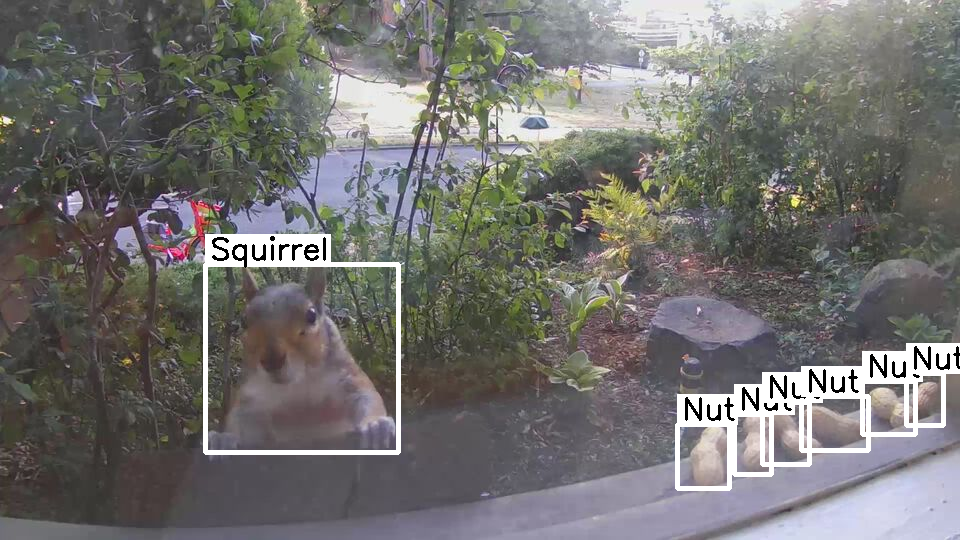

In [47]:
dataset.visualize.ShowBoundingBoxes("2021-07-03T06-49-05-frame_0002.jpeg")
#Original image

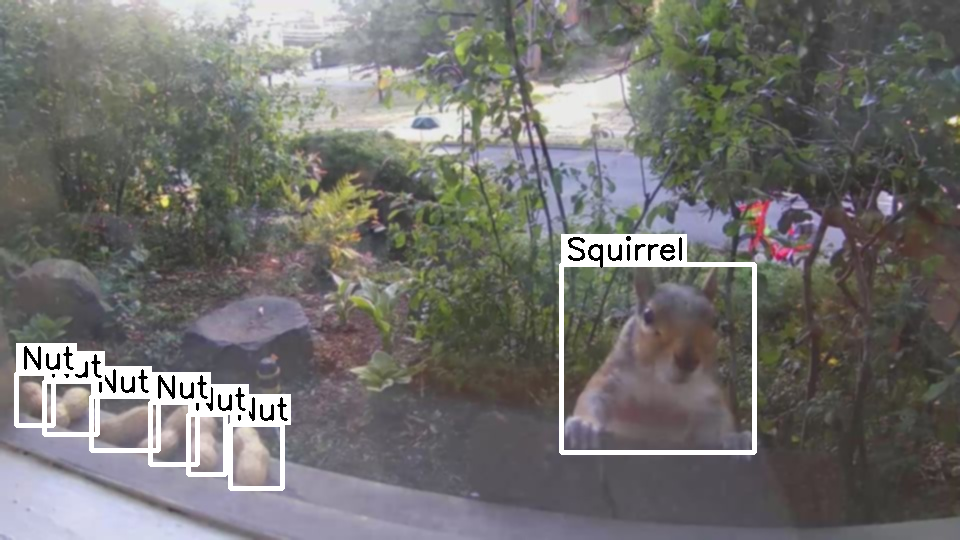

In [48]:
dataset.visualize.ShowBoundingBoxes("2021-07-03T06-49-05-frame_0002_augmented_0.jpeg")
# Flipped image

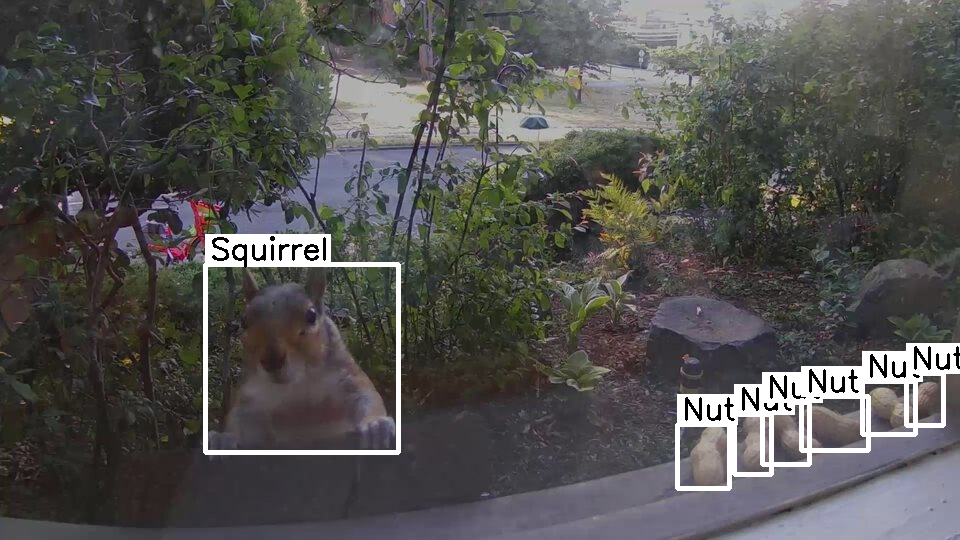

In [49]:
dataset.visualize.ShowBoundingBoxes("2021-07-03T06-49-05-frame_0002_augmented_2.jpeg")
#Darkened image

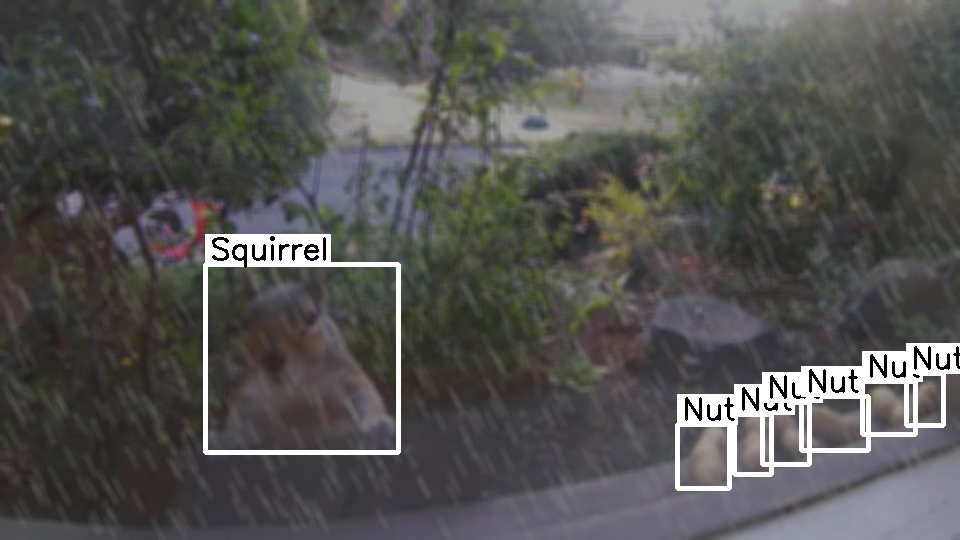

In [ ]:
dataset.visualize.ShowBoundingBoxes("2021-07-03T06-49-05-frame_0002_augmented_3.jpeg")
#Rainy image

Export the augmented dataset in the format of your choice. 

In [50]:
dataset.export.ExportToYoloV5(output_path='training/labels', yaml_file='dataset.yaml', copy_images=True, cat_id_index=0)[:2]


['training/dataset.yaml', 'training/labels/2021-07-03T06-30-10-frame_0001.txt']